# Prepare

In [1]:
import os # for file handling
import pathlib # for reading files
import pandas as pd # for reading csv files
import numpy as np # for numerical operations
from PIL import Image # for opening images
import shutil # for moving files
import matplotlib.pyplot as plt # for plotting

import tensorflow as tf # for deep learning
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Check GPU

In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Physical Devices:", tf.config.list_physical_devices('GPU'))


from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

TensorFlow version: 2.10.1
Num GPUs Available:  1
Physical Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
['/device:CPU:0', '/device:GPU:0']


# Load Data using Keras utility

In [3]:
data_dir = pathlib.Path('C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\cats_approach_training_2024_05_19\\categories')

Define parameters for loader

In [4]:
batch_size = 32
#Larger batches also provide a more accurate estimate of the gradient, but they require more memory.

img_height = 180 # Using the actual sizes takes too long for training.
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21306 files belonging to 2 classes.
Using 17045 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21306 files belonging to 2 classes.
Using 4261 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [7]:
class_names = train_ds.class_names
print(class_names)

['n', 'y']


# Visualize the Data

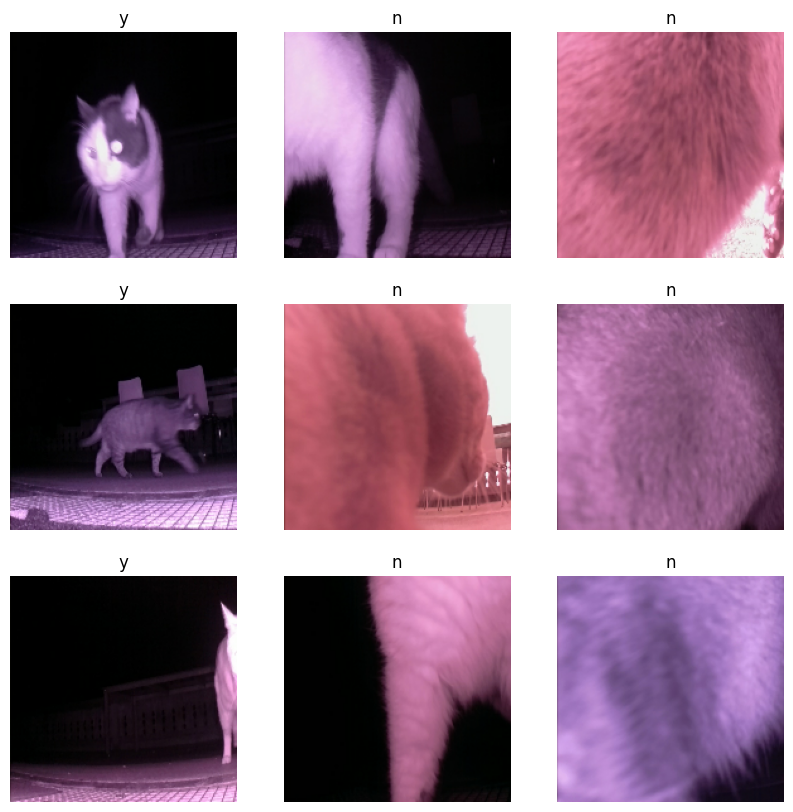

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


An image can be represented as a 3-D tensor. For a color image, the dimensions might correspond to height, width, and color channels (RGB). The `image_batch` is a tensor of the shape `(32, 480, 480, 3)`. This is a batch of 32 images of shape `480x480x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

# Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# A basic Keras model with Dropout Layers

### Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [9]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid') # Binary classification
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

Number of classes: 2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                               

In [10]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
533/533 [==============================] - 8s 8ms/step - loss: 0.4921 - accuracy: 0.7420 - val_loss: 0.4220 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 2/500
533/533 [==============================] - 3s 7ms/step - loss: 0.3908 - accuracy: 0.7944 - val_loss: 0.3638 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 3/500
533/533 [==============================] - 3s 7ms/step - loss: 0.3545 - accuracy: 0.8180 - val_loss: 0.3331 - val_accuracy: 0.8331 - lr: 0.0010
Epoch 4/500
533/533 [==============================] - 3s 7ms/step - loss: 0.3231 - accuracy: 0.8361 - val_loss: 0.2998 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 5/500
533/533 [==============================] - 3s 7ms/step - loss: 0.3005 - accuracy: 0.8535 - val_loss: 0.2925 - val_accuracy: 0.8561 - lr: 0.0010
Epoch 6/500
533/533 [==============================] - 3s 7ms/step - loss: 0.2719 - accuracy: 0.8655 - val_loss: 0.2839 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 7/500
533/533 [==============================] - 3s 7ms/st

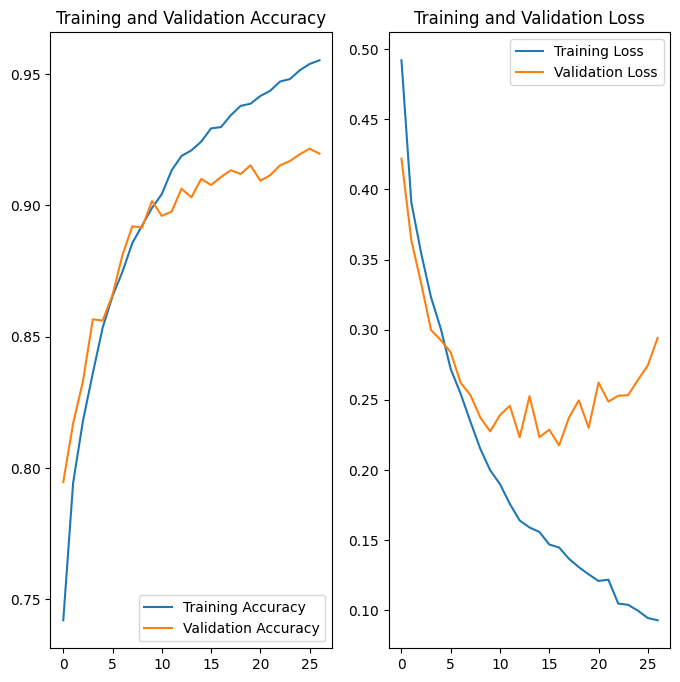

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(27) # adjust this to the number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Add Data Augmentation Layer

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Visualize Augmented Data

Visualize a few augmented examples by applying data augmentation to the same image several times:

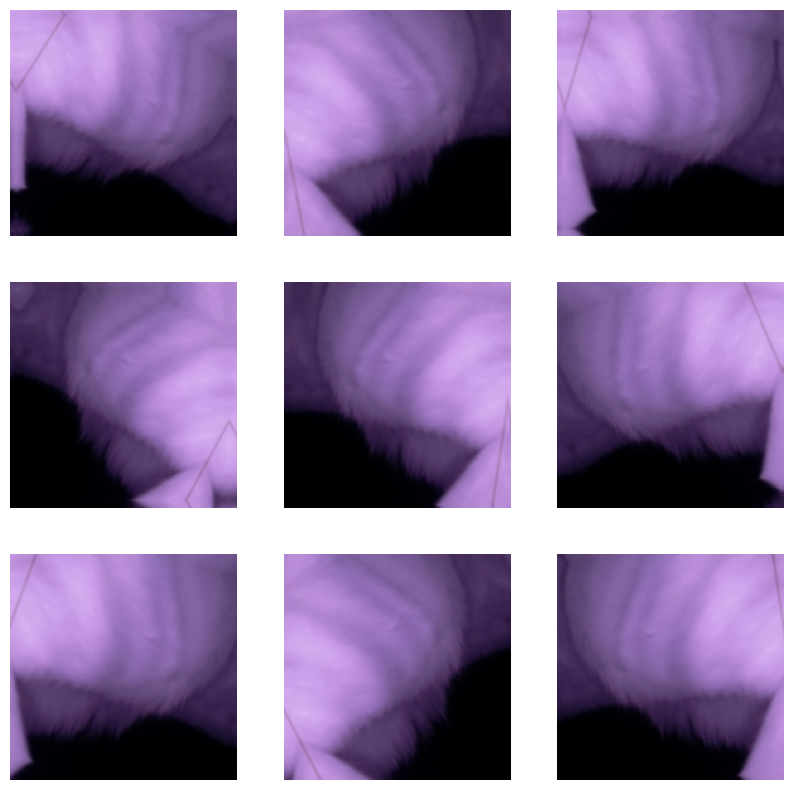

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create Model with Data Augmentation Layer

In [12]:
num_classes = len(class_names)
print("Number of classes:", num_classes)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),# input shape already defined in data_augmentation layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid') # Binary classification
])

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

model.summary()

Number of classes: 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                 

In [13]:
epochs = 500
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/500
533/533 [==============================] - 53s 97ms/step - loss: 0.4921 - accuracy: 0.7423 - val_loss: 0.4551 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 2/500
533/533 [==============================] - 52s 98ms/step - loss: 0.4373 - accuracy: 0.7614 - val_loss: 0.4166 - val_accuracy: 0.7756 - lr: 0.0010
Epoch 3/500
533/533 [==============================] - 51s 95ms/step - loss: 0.4131 - accuracy: 0.7791 - val_loss: 0.3981 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 4/500
533/533 [==============================] - 51s 95ms/step - loss: 0.3938 - accuracy: 0.7944 - val_loss: 0.3719 - val_accuracy: 0.8268 - lr: 0.0010
Epoch 5/500
533/533 [==============================] - 51s 95ms/step - loss: 0.3733 - accuracy: 0.8121 - val_loss: 0.3353 - val_accuracy: 0.8444 - lr: 0.0010
Epoch 6/500
533/533 [==============================] - 51s 96ms/step - loss: 0.3474 - accuracy: 0.8273 - val_loss: 0.3094 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 7/500
533/533 [==============================]

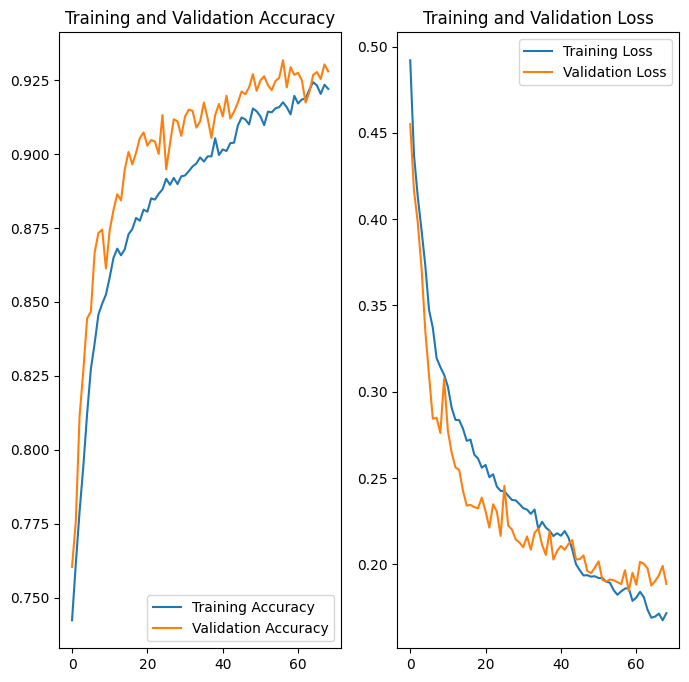

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(69) # adjust this to the number of epochs

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()